## Описание работы

Существует упрощённая модель данных стримингового сервиса

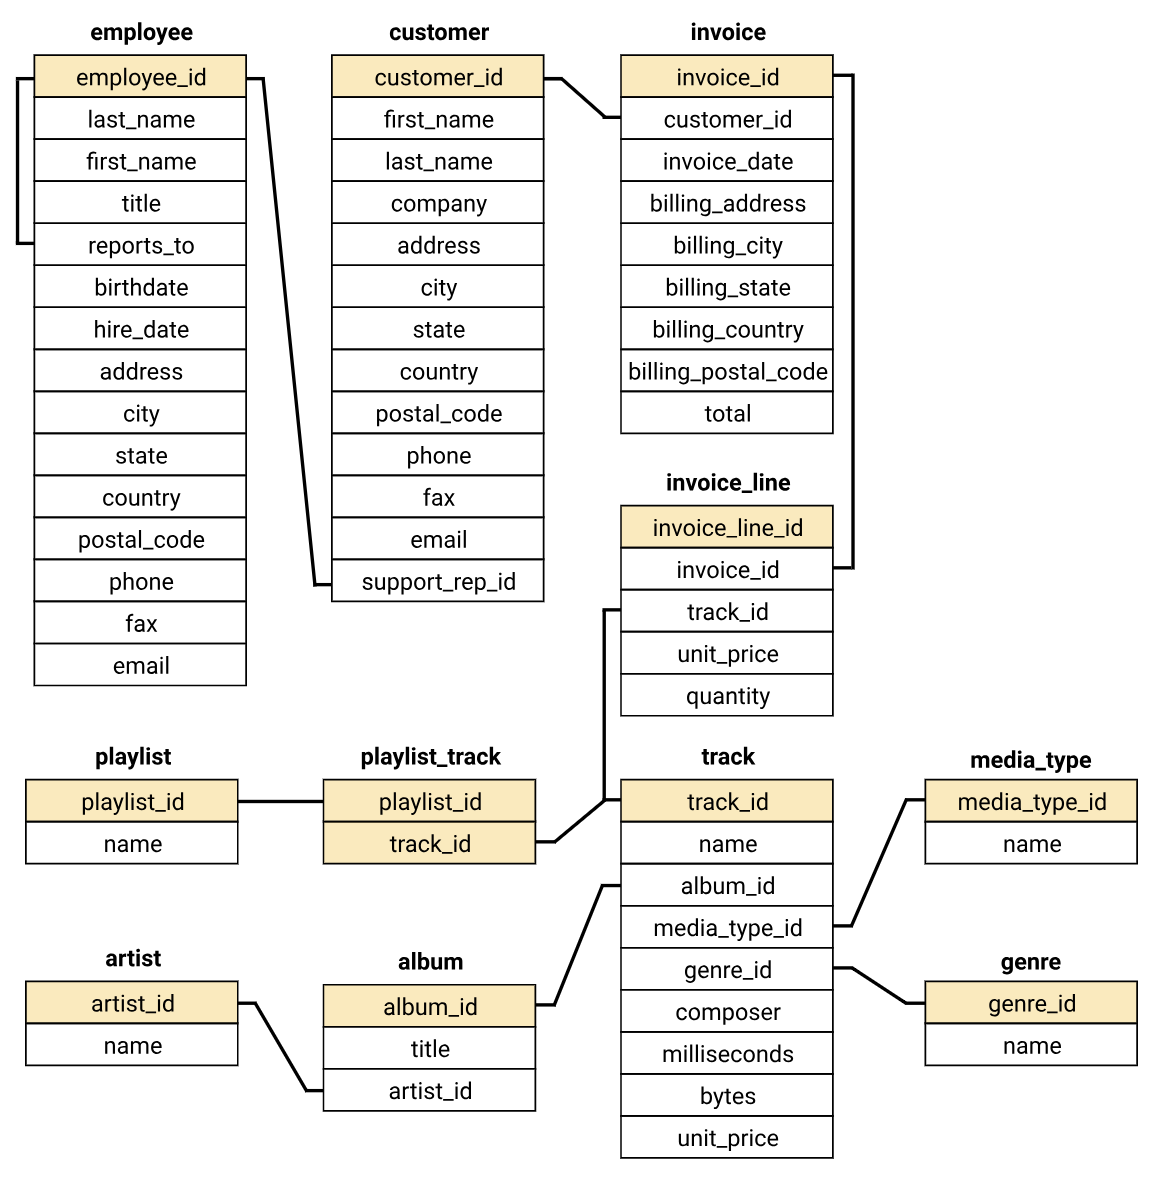

Цель работы - с помощью SQL получить данные из БД, подготовить и сделать выводы по графикам.

Задачи:
1) Построить графики, чтобы оценить по категориям жанров (‘rock’ и ‘others’) следующие ежемесячные показатели: общее количество купленных треков, число чеков, число покупателей, общую стоимость треков;

2) Сделать выводы по графикам.

## 1. Импорт сторонних библиотек

In [31]:
import pandas as pd
import datetime
import missingno as msno
import seaborn as sns
import sqlite3 as sql
import matplotlib.pyplot as plt

## 2. Загрузка данных

1. Подключение к базе данных. Вывод всех имеющихся таблиц

In [2]:
dbfile = 'Данные для кейса/chinook.db'
conn = sql.connect(dbfile)
cursor = conn.cursor()

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f'Table Name: {cursor.fetchall()}')

Table Name: [('album',), ('artist',), ('customer',), ('employee',), ('genre',), ('invoice',), ('invoice_line',), ('media_type',), ('playlist',), ('playlist_track',), ('track',)]


2. Запрос, в результате которого получится таблица с данными только по аудиофайлам (нужно проверить media_type) и только за 2020 год , содержащая:
- данные о чеках (invoice): id, дату;
- id покупателя и id всех треков в чеке;
- жанр каждого трека c объединением всех тяжёлых жанров (Rock, Alternative & Punk, Metal, Alternative, Heavy Metal) в категорию ‘rock’, а остальные жанры — в категорию ‘others’;
- стоимость трека.

На основе запроса создадим датафрейм

In [4]:
df = pd.read_sql_query("WITH genre_name AS ( \
                        SELECT tr.track_id, \
                        mt.name, \
                        CASE \
                        WHEN gnr.name = 'Rock' OR gnr.name = 'Alternative & Punk' OR gnr.name = 'Metal' OR gnr.name = 'Alternative' OR gnr.name = 'Heavy Metal' THEN 'rock' \
                        ELSE 'others' \
                        END as genre_name \
                        FROM track as tr \
                        INNER JOIN genre as gnr \
                        ON tr.genre_id = gnr.genre_id \
                        INNER JOIN media_type as mt \
                        ON tr.media_type_id = mt.media_type_id \
                        ) \
                        SELECT inv.invoice_id, inv.invoice_date, \
                        cst.customer_id, \
                        invl.track_id, \
                        gn.genre_name, \
                        invl.unit_price \
                        FROM invoice as inv \
                        INNER JOIN customer as cst \
                        ON inv.customer_id = cst.customer_id \
                        INNER JOIN invoice_line as invl \
                        ON inv.invoice_id = invl.invoice_id \
                        INNER JOIN genre_name as gn \
                        ON invl.track_id = gn.track_id \
                        WHERE gn.name != 'Protected MPEG-4 video file'\
                        ;", conn)
conn.close()

In [5]:
df.head()

,invoice_id,invoice_date,customer_id,track_id,genre_name,unit_price
0,1,2017-01-03 00:00:00,18,1158,rock,0.99
1,1,2017-01-03 00:00:00,18,1159,rock,0.99
2,1,2017-01-03 00:00:00,18,1160,rock,0.99
3,1,2017-01-03 00:00:00,18,1161,rock,0.99
4,1,2017-01-03 00:00:00,18,1162,rock,0.99


## 3. Data Preparation

### 3.1 Преобразование типов данных

1. Вывод общей информации о датасетах для анализа типа данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_id    4754 non-null   int64  
 1   invoice_date  4754 non-null   object 
 2   customer_id   4754 non-null   int64  
 3   track_id      4754 non-null   int64  
 4   genre_name    4754 non-null   object 
 5   unit_price    4754 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 223.0+ KB


2. Изменение типа данных для дат на Datetime-формат

In [7]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], infer_datetime_format=True, utc=True)

3. Проверка итогового типа

In [8]:
print(f' Тип данных для invoice_date: {df.invoice_date.dtype}')

 Тип данных для invoice_date: datetime64[ns, UTC]


Вывод данных только за 2020 год

In [9]:
df = df[df.invoice_date.dt.year == 2020]

### 3.2 Исследование данных на дубликаты и пропуски

1. Вывод матрицы пропусков для `df`

Матрица пропусков


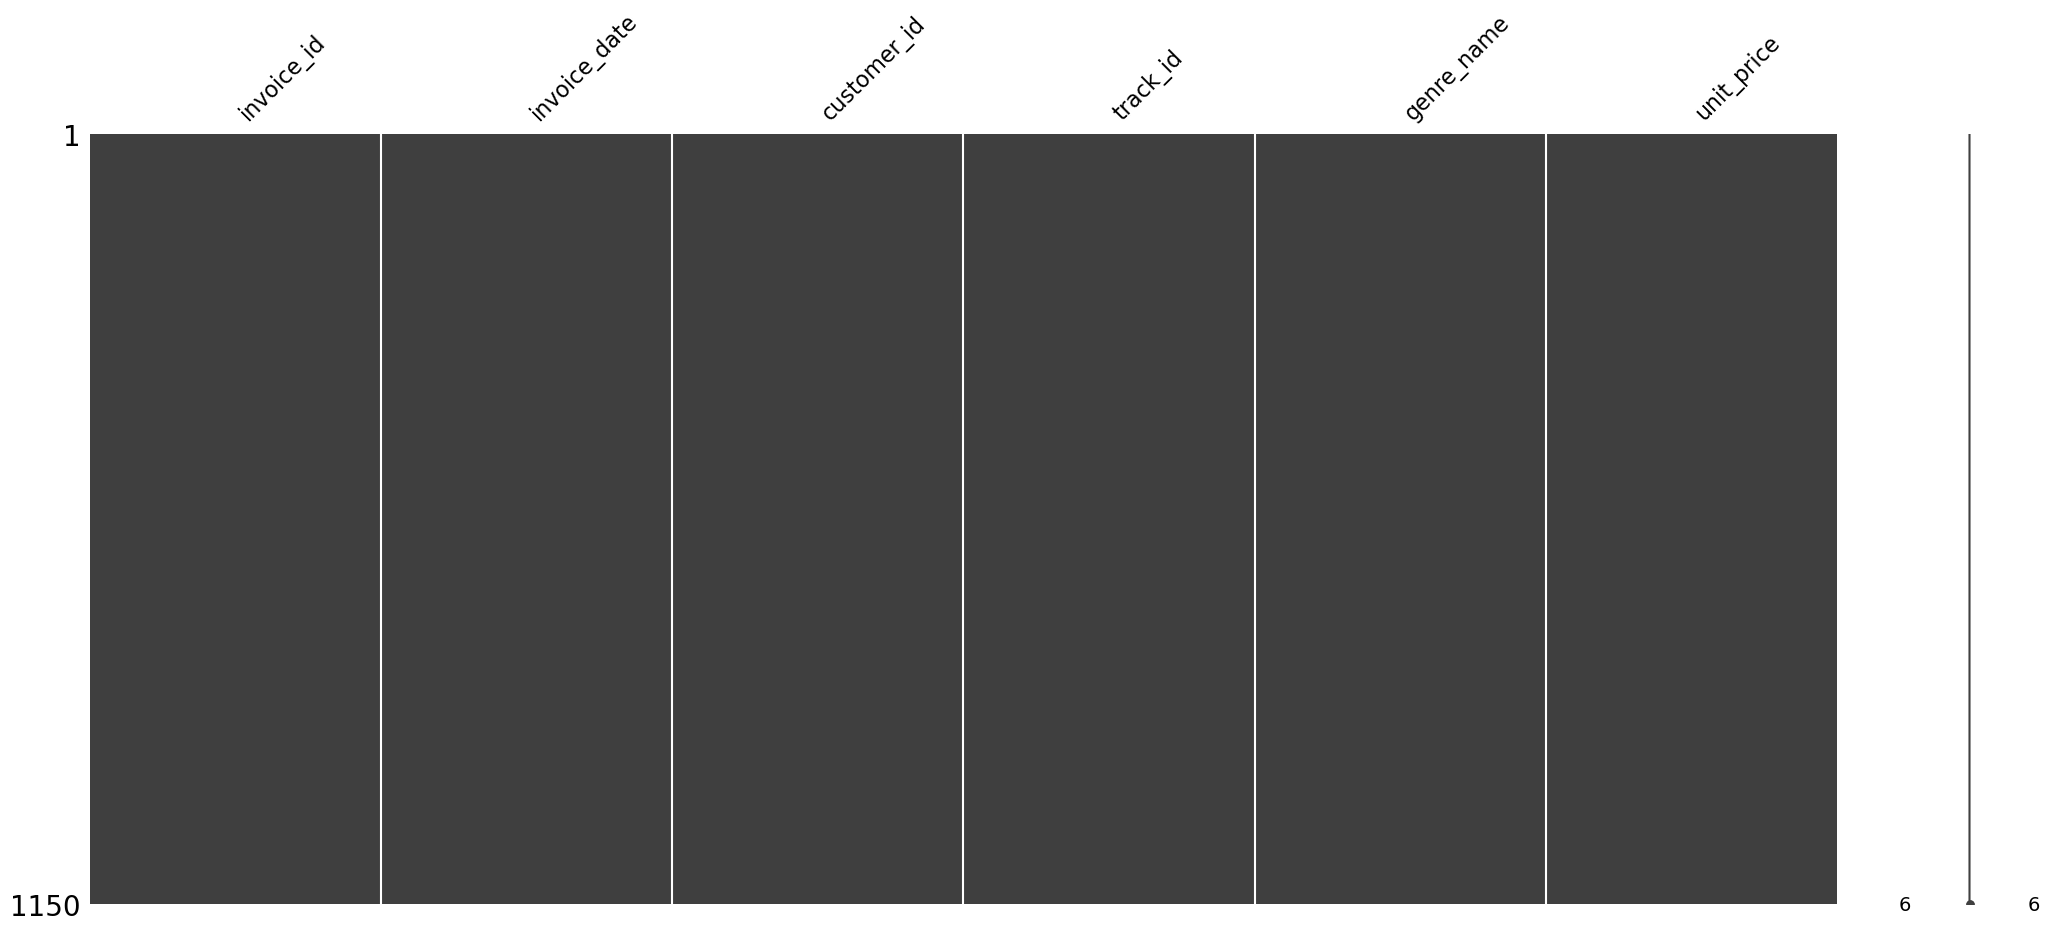

In [10]:
print('Матрица пропусков')
msno.matrix(df);

2. Вывод количества полностью заполненных объектов и показатель плотности данных.

In [11]:
print(f'Количество полностью заполненных объектов для датасета: {len(df.dropna())}')
print(f'Плотность данных: {round((len(df.dropna()) / len(df)) * 100 , 2)} %')

Количество полностью заполненных объектов для датасета: 1150
Плотность данных: 100.0 %


Пропусков в данных не обнаружено.

3. Выявление дубликатов `df`. Подсчёт значения уникальности данных

In [12]:
print(f'Уникальность данных составляет: {round(df.drop_duplicates().shape[0] / df.shape[0], 5)}')

Уникальность данных составляет: 0.99826


4. Сделаем копию датасета и удалим дубликаты

In [13]:
df_clean = df.copy()

df_clean = df_clean.drop_duplicates()
df_clean

,invoice_id,invoice_date,customer_id,track_id,genre_name,unit_price
3604,465,2020-01-12 00:00:00+00:00,21,149,rock,0.99
3605,465,2020-01-12 00:00:00+00:00,21,150,rock,0.99
3606,465,2020-01-12 00:00:00+00:00,21,151,rock,0.99
3607,465,2020-01-12 00:00:00+00:00,21,152,rock,0.99
3608,465,2020-01-12 00:00:00+00:00,21,153,rock,0.99
...,...,...,...,...,...,...
4749,614,2020-12-30 00:00:00+00:00,53,2659,rock,0.99
4750,614,2020-12-30 00:00:00+00:00,53,2660,rock,0.99
4751,614,2020-12-30 00:00:00+00:00,53,2661,rock,0.99
4752,614,2020-12-30 00:00:00+00:00,53,2662,rock,0.99


### 3.3 Создание новых признаков на основе информации в датасете

1. Приведём дату к первому числу каждого месяца

In [14]:
df_clean['invoice_date_cnvt'] = df_clean.invoice_date.apply(lambda x: pd.offsets.MonthBegin().rollback(x))

In [15]:
df_clean['invoice_date_cnvt'] = df_clean.invoice_date_cnvt.dt.date

## 4. Data Visualization

### 4.1 Ежемесячные показатели в разрезе жанров 

1. Подготовка данных

In [16]:
stat = df_clean.groupby(['invoice_date_cnvt', 'genre_name']).agg(
    {'track_id' : 'count' , 
     'invoice_id' : 'nunique' , 
     'customer_id' : 'nunique', 
     'unit_price' : 'sum'}
).rename(columns=
         {"track_id": "track_id_cnt",
         "invoice_id": "invoice_id_nuq",
         "customer_id": "customer_id_nuq",
         "unit_price": "unit_price_sum"})

In [17]:
stat

track_id_cnt  invoice_id_nuq  customer_id_nuq  \
invoice_date_cnvt genre_name                                                  
2020-01-01        others                 6               3                3   
                  rock                  38               8                8   
2020-02-01        others                 5               4                4   
                  rock                  93              11               11   
2020-03-01        others                21               6                6   
                  rock                  58              10               10   
2020-04-01        others                15               8                8   
                  rock                 106              15               15   
2020-05-01        others                16               8                7   
                  rock                  66              13               11   
2020-06-01        others                21               5                5   
                  rock                 101              10               10   
2020-07-01        others                20               8                7   
                  rock                  57              10                9   
2020-08-01        others                13               5                3   
                  rock                  60               8                6   
2020-09-01        others                25              10               10   
                  rock                  71              12               10   
2020-10-01        others                50              13               13   
                  rock                  96              16               16   
2020-11-01        others                15               6                6   
                  rock                  68              12               11   
2020-12-01        others                29               7                7   
                  rock                  98              16               14   

                              unit_price_sum  
invoice_date_cnvt genre_name                  
2020-01-01        others                5.94  
                  rock                 37.62  
2020-02-01        others                4.95  
                  rock                 92.07  
2020-03-01        others               20.79  
                  rock                 57.42  
2020-04-01        others               14.85  
                  rock                104.94  
2020-05-01        others               15.84  
                  rock                 65.34  
2020-06-01        others               20.79  
                  rock                 99.99  
2020-07-01        others               19.80  
                  rock                 56.43  
2020-08-01        others               12.87  
                  rock                 59.40  
2020-09-01        others               24.75  
                  rock                 70.29  
2020-10-01        others               49.50  
                  rock                 95.04  
2020-11-01        others               14.85  
                  rock                 67.32  
2020-12-01        others               28.71  
                  rock                 97.02

2. Визуализируем полученную группу

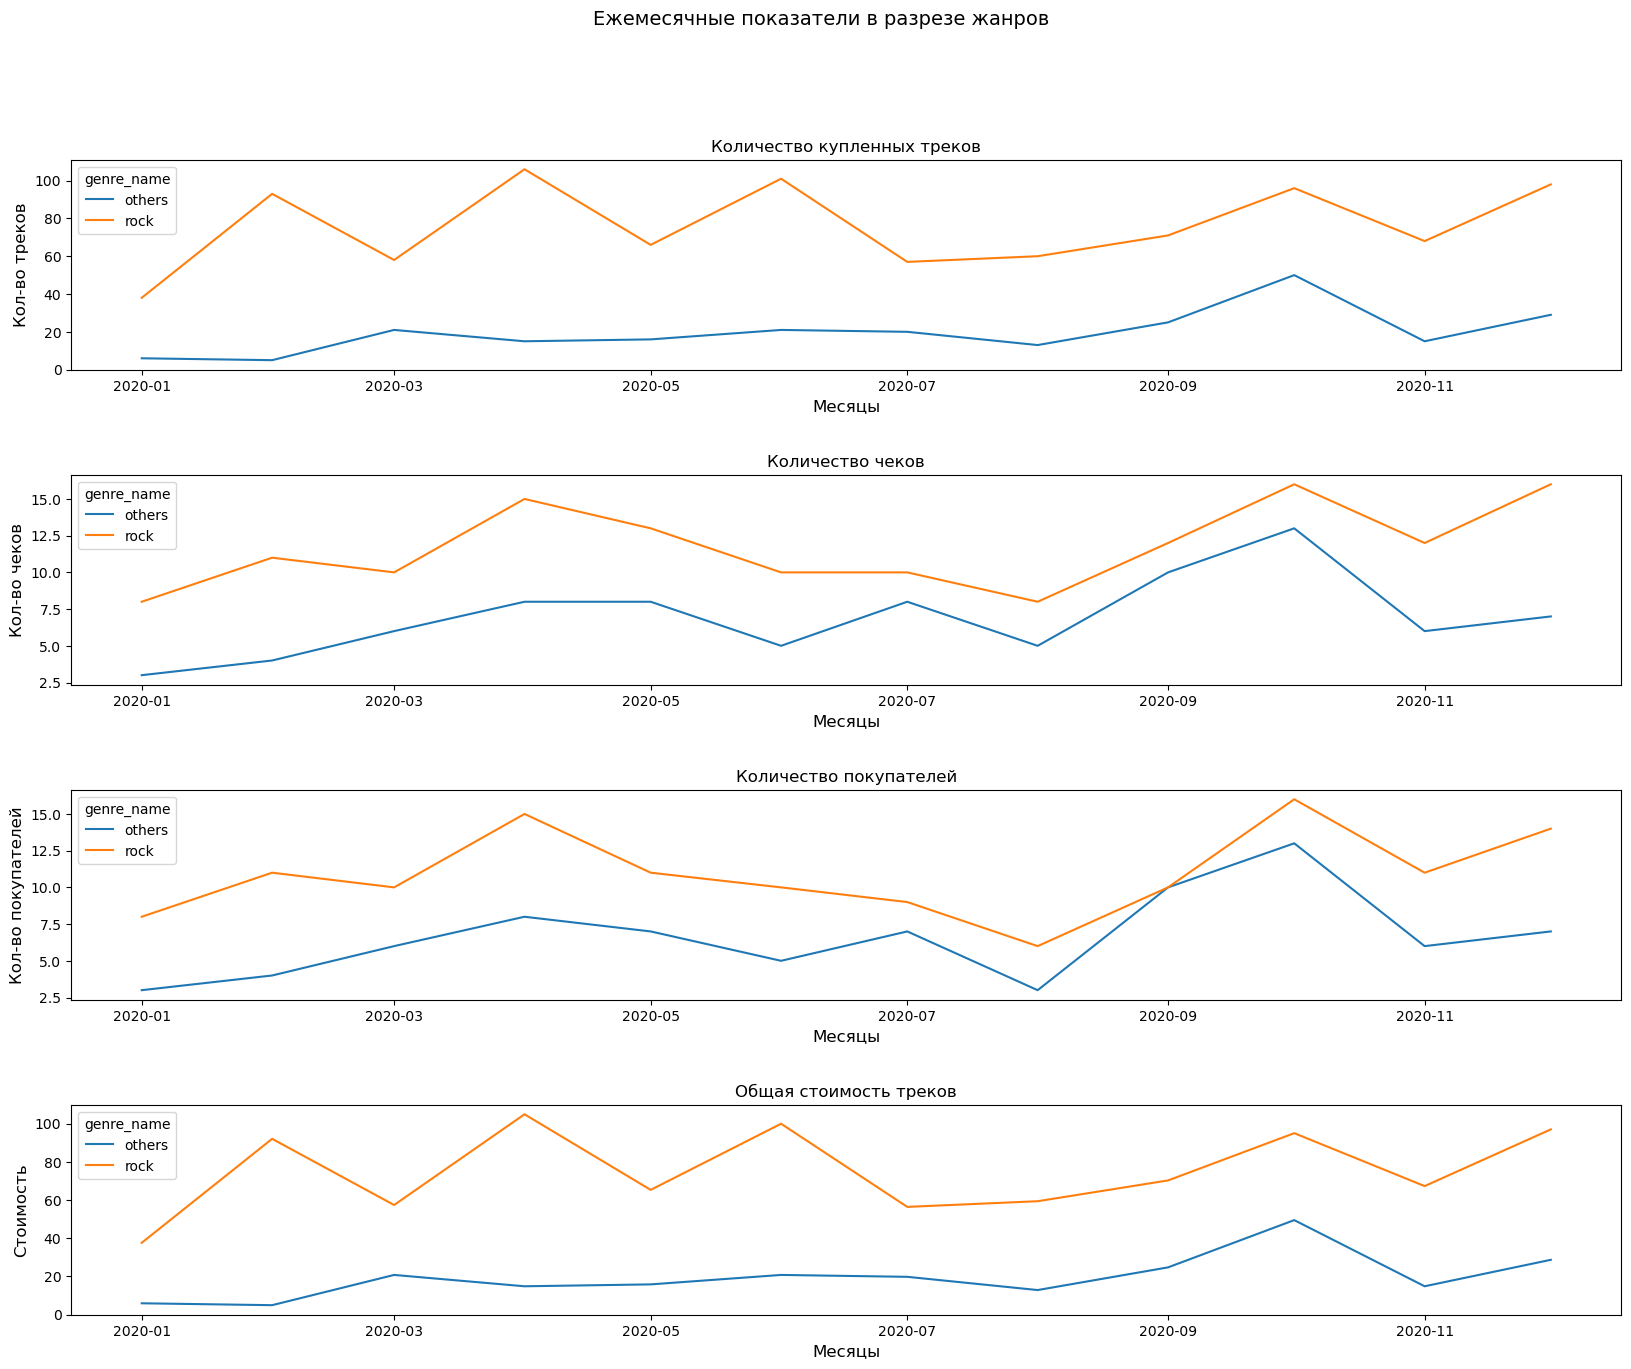

In [42]:
fig, ax = plt.subplots(4, 1, figsize = (20, 15))
fig.suptitle('Ежемесячные показатели в разрезе жанров', fontsize = 14)
fig.subplots_adjust(hspace = 0.5)

sns.lineplot(data = stat, x = "invoice_date_cnvt", y = "track_id_cnt", hue = "genre_name", ax = ax[0])
ax[0].set_title('Количество купленных треков', fontsize = 12)
ax[0].set_xlabel('Месяцы', fontsize = 12)
ax[0].set_ylabel('Кол-во треков', fontsize = 12)

sns.lineplot(data = stat, x = "invoice_date_cnvt", y = "invoice_id_nuq", hue = "genre_name", ax = ax[1])
ax[1].set_title('Количество чеков', fontsize = 12)
ax[1].set_xlabel('Месяцы', fontsize = 12)
ax[1].set_ylabel('Кол-во чеков', fontsize = 12)


sns.lineplot(data = stat, x = "invoice_date_cnvt", y = "customer_id_nuq", hue = "genre_name", ax = ax[2])
ax[2].set_title('Количество покупателей', fontsize = 12)
ax[2].set_xlabel('Месяцы', fontsize = 12)
ax[2].set_ylabel('Кол-во покупателей', fontsize = 12)

sns.lineplot(data = stat, x = "invoice_date_cnvt", y = "unit_price_sum", hue = "genre_name", ax = ax[3])
ax[3].set_title('Общая стоимость треков', fontsize = 12)
ax[3].set_xlabel('Месяцы', fontsize = 12)
ax[3].set_ylabel('Стоимость', fontsize = 12)

plt.show()

3. Вывод

Исходя из представленных графиков можно сделать вывод, что треки с жанром `rock` более результативны по всем четырём показателям. 